In [180]:
#System
import sys
import os

#Api SRC
import tweepy
sys.path.insert(1, '../../')
import keys # tokens ficam acima da pasta do projeto

#text
from datetime import datetime
import string
from collections import Counter
from unidecode import unidecode #
import re

#visual
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyLDAvis.gensim #
from mpl_toolkits import mplot3d

#ml
import gensim
import pickle #
import nltk

#skl
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS

#math
import random

import pandas as pd

%matplotlib inline

In [18]:
#api conf
auth = tweepy.OAuthHandler(keys.cos_pub, keys.cos_sec)
auth.set_access_token(keys.as_pub, keys.as_sec)

api = tweepy.API(auth) 
data_folder = '../data/'

In [19]:
#getting data
#TODO criar um gerador de termos de pesquisa
search_terms = [
    'lula',
    'presidente',
    'bosolnaro',
    'lulalivre',
    'stf',
    'vergonha nacional',
    'sergio moro',
    'pt',
    'brasil',
    'bolsominion',
    'segunda instância',
    'pec 410/18',
    'lava jato',
    'intercept',
    'vaza jato'
]
def twitter_search(terms):
    tmp_search_result = []
 
    for e in terms:
        partial_result = [];
        #API limita o acesso aos 100 ultimos tweets de uma pesquisa usando licensa não comercial
        api_result = api.search(q=e, tweet_mode='extended', count=100, lang='pt', retweeted=False, reply=False)

        for prop in api_result:
            partial_result.append(prop._json['full_text'])
        tmp_search_result.extend(partial_result)
        
    return tmp_search_result
search_result = set(twitter_search(search_terms)) # removendo tweets duplicados
search_result

{'"Ele foi eleito para governar para todos os brasileiros, não para os milicianos do Rio de Janeiro", dispara Lula. Ex-presidente critica ainda interferência de Bolsonaro na investigação do assassinato de Marielle. "Ele tem que explicar o Queiroz", provoca.',
 '"Onde está o Queiroz? Eu quero saber como é que estes caras juntam dinheiro!"\n🔴 AO VIVO – Pronunciamento de Lula ao povo brasileiro no Sindicato dos Metalúrgicos do ABC https://t.co/ZyQEbTNkco #LulaLivre',
 '"Se você pegar a vida dele (Bolsonaro), você vai ver que ele arranjou um jeito de não trabalhar!" Lula em São Bernardo do Campo. #LulaTaLivreCompanheiro #LulaLivre',
 '"eu fui deputado, fui presidente e se me virar de cabeça pra baixo não vai cair uma moeda do meu bolso" #LulaLivre #LulaTaLivreBabaca',
 '#Lula quanto ataca o governo, ataca o governo, não ataca quem não vorou nele. Quando fala do povo,  fala do povo, não de quem votou nele. Ele não divide o povo em "quem votou em mim e quem votou no outro". O povo é o povo. 

In [20]:
#saving data in a txt file

data_path = '{0}{1}/'.format(data_folder, datetime.now(tz=None))
graphics_path = data_path +'graphics/' 
separator = ' \n || \n '

os.makedirs(graphics_path)

#raw file
with open(data_path+'raw.txt', 'wb') as file:
    for e in search_result:
        entry = '{0}{1}'.format(e.splitlines(), separator) #tweet separator
        file.write(entry.encode())
    file.close()
    
#search terms
with open(data_path+'search_terms.txt', 'wb') as file:
    entry = ' '.join(search_terms)
    file.write(entry.encode())
    file.close()
    
with open(data_path+'raw_separator.txt', 'wb') as file:
    file.write(separator.encode())
    file.close()

In [21]:
#filtrando texto
def filter_text(txt):
    # juntando todas as sentenças e removendo \n
    text = ''.join(''.join(txt).splitlines())
    text = unidecode(text)
    #nltk.download('stopwords')
    stop_words = nltk.corpus.stopwords.words('portuguese')
    stop_words.extend(['', 'rt', 'nao', 'pra', 'q']) #tirando espaços vazios e marcas de retweet
    
    w_list = []
    w_list = text.split()
    w_list = [e.strip().strip(string.punctuation).lower() for e in w_list]
    w_list = filter(None, w_list)
    w_list = [e for e in w_list if "https" not in e and e[0] !=  '@'] #tirando  links e menções  
    
    w_filtered = ' '.join(w_list)
    
    #removendo caracteres não alfanuméricos de dentro da string e stop_words
    w_list = [e for e in re.sub('[^A-Za-z0-9]+', ' ', w_filtered).split(' ') if e not in stop_words ]
    w_filtered = ' '.join(w_list) #atualizando texto filtrado

    return {
        'text': w_filtered,
        'list': w_list
    }
text = filter_text(search_result)

words_list = text['list']
filtered_words = text['text']

print('List:\n{0}\n\nWords:'.format(words_list[:40]))
print(filtered_words[:200])

List:
['carlosbolsonaro', 'presidente', 'jairbolsonaro', 'enaltece', 'sf', 'moro', 'apos', 'decisao', 'stf', 'liberta', 'lula', 'duvidas', 'jogo', 'vira', 'leandraleal', 'leandraleal', 'lula', 'livre', 'ze', 'dirceu', 'tambem', 'abdelmassih', 'chegando', 'renan', 'penha', 'bem', 'vindo', 'ola', 'sergio', 'cabral', 'bora', 'fazer', 'churras', 'ta', 'melhorando', 'pessoal', 'pcc', 'ja', 'advogados', 'porta']

Words:
carlosbolsonaro presidente jairbolsonaro enaltece sf moro apos decisao stf liberta lula duvidas jogo vira leandraleal leandraleal lula livre ze dirceu tambem abdelmassih chegando renan penha bem vindo


In [22]:
filtered_sentenses = []
for e in search_result:
    filtered_sentenses.append(filter_text(e)['list'])
    
#filtered tweets
with open(data_path+'filtered_tweets.txt', 'wb') as file:
    tmpTxt = ''
    for e in filtered_sentenses:
        tmpTxt = tmpTxt + ' '.join(e) + '\n'
        
    file.write(tmpTxt.encode())
    file.close()    

print(filtered_sentenses)

[['carlosbolsonaro', 'presidente', 'jairbolsonaro', 'enaltece', 'sf', 'moro', 'apos', 'decisao', 'stf', 'liberta', 'lula', 'duvidas', 'jogo', 'vira'], ['leandraleal', 'leandraleal', 'lula', 'livre', 'ze', 'dirceu', 'tambem', 'abdelmassih', 'chegando', 'renan', 'penha', 'bem', 'vindo', 'ola', 'sergio', 'cabral', 'bora', 'fazer', 'churras', 'ta', 'melhorando', 'pessoal', 'pcc', 'ja', 'advogados', 'porta', 'colonia', 'penal', 'amanha', 'casa', 'leandra', 'partir', '11h'], ['filhotourinho', 'thameadanelon', 'emanoel1953', 'sf', 'moro', 'tacladuran', 'leva', 'jato', 'voce', 'quer', 'dizer', 'vaza', 'jato'], ['momiguel', 'todos', 'devemos', 'the', 'intercept', 'caras', 'escancararam', 'face', 'politico', 'mafiosa', 'lavajato', 'tal', 'maneira', 'stf', 'podia', 'fingir', 'vendo', 'olha', 'so', 'odio', 'ilustrado', 'covarde', 'agressao', 'glenngreenwald', 'orquestrada', 'jovempan', 'medo'], ['pedro', 'lupion', 'antagonista', 'lula', 'decolou', 'sao', 'bernardo', 'campo', 'jatinho', 'empresa', 

In [23]:
#termos mais frequentes
frequence_list= []
frequence_list = Counter(words_list)

frequence_list.most_common(20)

[('lula', 271),
 ('stf', 152),
 ('presidente', 100),
 ('vergonha', 99),
 ('brasil', 96),
 ('moro', 94),
 ('jato', 89),
 ('prisao', 89),
 ('ser', 78),
 ('nacional', 76),
 ('instancia', 70),
 ('bolsonaro', 65),
 ('vai', 62),
 ('pt', 61),
 ('segunda', 60),
 ('bosolnaro', 59),
 ('ja', 57),
 ('intercept', 52),
 ('sao', 50),
 ('so', 49)]

In [24]:
word_cloud = WordCloud(max_font_size=50).generate(filtered_words)

with open(data_path+'filtered_words_soup.txt', "wb") as file:
    file.write(filtered_words.encode())
    file.close()

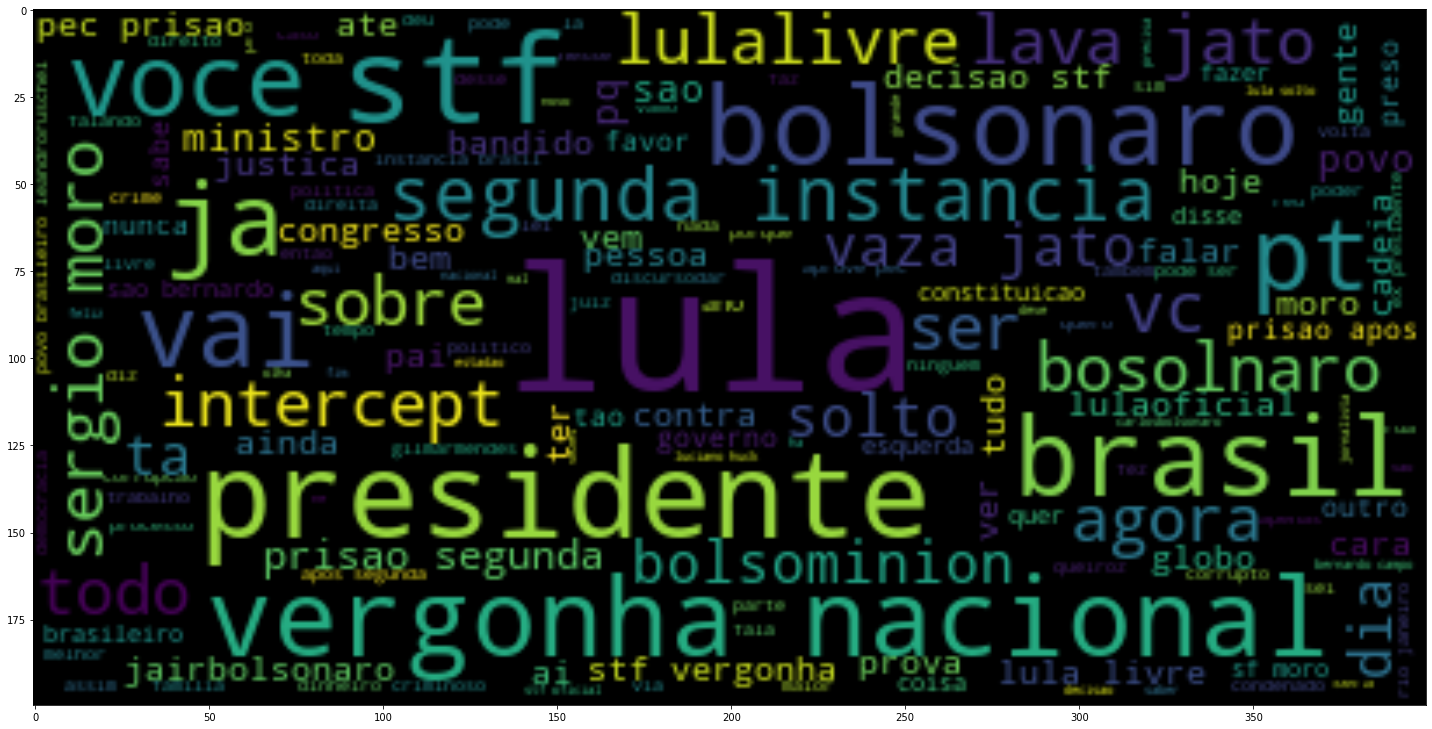

In [25]:
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(word_cloud, interpolation='bilinear')
plt.axis(label= 'Nearest')
plt.tight_layout()
plt.savefig(graphics_path+'w_c_near.png', dpi=90)
plt.show()

In [26]:
#algoritmo que mostra vizinhos
expression = "politica"

positions = [] #localização onde a plavra se encontra
for i, e in enumerate(words_list):
    if expression == e:
        positions.append(i)

print(len(positions))
print(positions)

14
[1458, 1742, 3114, 5591, 5773, 6221, 6691, 6956, 7127, 9091, 9248, 10069, 10406, 11455]


In [27]:
neighbors = 2
for e in positions[0:30]:
    print(words_list[e-neighbors : e+neighbors+1])

['dia', 'palmeiras', 'politica', 'futebol', 'igual']
['carente', 'figura', 'politica', 'aceitam', 'qualquer']
['evoluir', 'vida', 'politica', 'jessemourap', 'vitormatheuzzz']
['lula', 'prisao', 'politica', 'processo', 'inteiro']
['prisao', 'lula', 'politica', 'voce', 'pegar']
['ta', 'gostando', 'politica', 'economica', 'jegues']
['nada', 'direito', 'politica', 'sabe', 'aconteceu']
['entendem', 'nada', 'politica', 'entendem', 'surfar']
['termina', 'prisao', 'politica', 'lula', 'armacao']
['maior', 'lideranca', 'politica', 'pais', 'ne']
['pt', 'messianismo', 'politica', 'conciliacao', 'classe']
['constituicao', 'historia', 'politica', 'brasileira', 'dando']
['posso', 'falar', 'politica', 'porque', 'entendo']
['alguem', 'habilidade', 'politica', 'lula', 'cima']


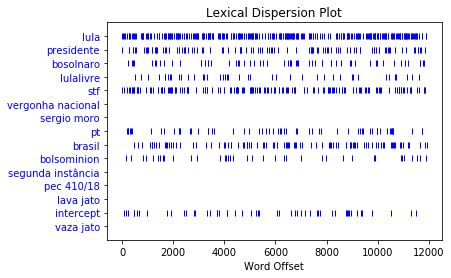

In [28]:
tknzr = nltk.tokenize.WordPunctTokenizer()
tokens = tknzr.tokenize(filtered_words)
nltk_text = nltk.Text(tokens)

nltk_text.dispersion_plot(search_terms)

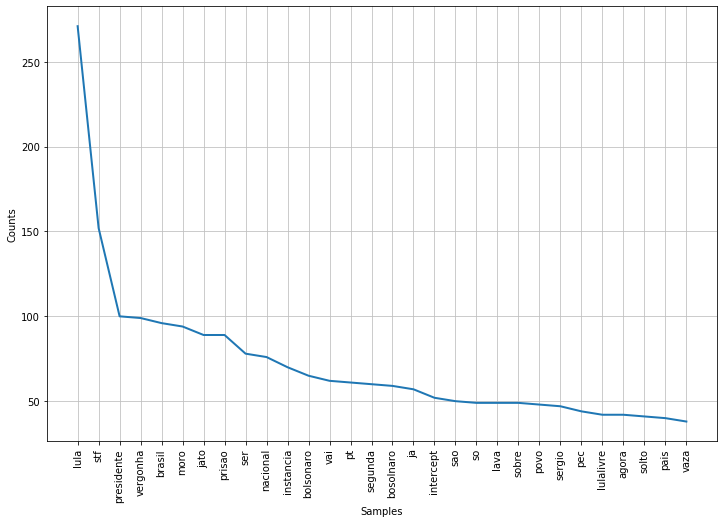

In [29]:
fd_words = nltk.FreqDist(tokens)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8)) 
fd_words.plot(30)

In [44]:
#bag of words
corpus_path = data_path+'corpus.pkl'
dict_path = data_path+'dictionary.gensim'

dictionary = gensim.corpora.Dictionary(filtered_sentenses)
corpus = [dictionary.doc2bow(e) for e in filtered_sentenses]

#generating dict
pickle.dump(corpus, open( corpus_path, 'wb'))
dictionary.save(dict_path)

In [31]:
n_topics = 5 #número de tópicos
n_words = 5 #número de palavras relacionadas
lda_model_path = data_path+'my_cur_model_{0}t_{1}.gensim'.format(str(n_topics), str(n_words))

lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics = n_topics, id2word=dictionary, passes=15)
lda_model.save(lda_model_path)
topics = lda_model.print_topics(num_words= n_words) #palaras por array
for e in topics:
    print(str(e)+'\n')

(0, '0.025*"lula" + 0.011*"moro" + 0.008*"stf" + 0.008*"sergio" + 0.007*"bolsonaro"')

(1, '0.011*"lula" + 0.008*"brasil" + 0.006*"bolsominion" + 0.006*"presidente" + 0.006*"ser"')

(2, '0.022*"lula" + 0.021*"vergonha" + 0.018*"nacional" + 0.017*"stf" + 0.008*"bosolnaro"')

(3, '0.011*"lula" + 0.007*"ta" + 0.006*"lulalivre" + 0.005*"ja" + 0.005*"stf"')

(4, '0.013*"jato" + 0.012*"prisao" + 0.012*"instancia" + 0.012*"lula" + 0.012*"presidente"')



In [32]:
#manter as duas tarefas de visualização das relações entre tópicos e palavras separadas, pois são tarefas demoradas
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)

/home/albrigs/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [33]:
pyLDAvis.display(lda_display)

In [34]:
print(search_terms)

['vaza jato', 'intercept', 'lava jato', 'pec 410/18', 'segunda instância', 'bolsominion', 'brasil', 'pt', 'sergio moro', 'vergonha nacional', 'stf', 'lulalivre', 'bosolnaro', 'presidente', 'lula']


In [35]:
print(data_path)

../data/2019-11-09 15:17:07.662330/


In [123]:
#clusterização
tf_idf_vec = TfidfVectorizer()
content_tf_idf = tf_idf_vec.fit_transform(words_list)
print(content_tf_idf)

  (0, 748)	1.0
  (1, 3386)	1.0
  (2, 2249)	1.0
  (3, 1504)	1.0
  (4, 3845)	1.0
  (5, 2800)	1.0
  (6, 360)	1.0
  (7, 1176)	1.0
  (8, 3942)	1.0
  (9, 2438)	1.0
  (10, 2519)	1.0
  (11, 1437)	1.0
  (12, 2280)	1.0
  (13, 4306)	1.0
  (14, 2392)	1.0
  (15, 2392)	1.0
  (16, 2519)	1.0
  (17, 2468)	1.0
  (18, 4389)	1.0
  (19, 1362)	1.0
  (20, 3995)	1.0
  (21, 82)	1.0
  (22, 822)	1.0
  (23, 3616)	1.0
  (24, 3180)	1.0
  :	:
  (11923, 2813)	1.0
  (11924, 1406)	1.0
  (11925, 3752)	1.0
  (11926, 674)	1.0
  (11927, 1322)	1.0
  (11928, 4036)	1.0
  (11929, 1541)	1.0
  (11930, 1546)	1.0
  (11931, 2058)	1.0
  (11932, 3760)	1.0
  (11933, 2390)	1.0
  (11934, 1838)	1.0
  (11935, 2373)	1.0
  (11936, 1721)	1.0
  (11937, 1797)	1.0
  (11938, 2458)	1.0
  (11939, 3544)	1.0
  (11940, 3883)	1.0
  (11941, 1540)	1.0
  (11942, 4227)	1.0
  (11943, 2254)	1.0
  (11944, 3340)	1.0
  (11945, 2800)	1.0
  (11946, 1087)	1.0
  (11947, 3296)	1.0


In [133]:
#vetorizando para passar por clusterização
tfidf_vectorizer = TfidfVectorizer(
    use_idf=True 
)
sentenses = [' '.join(e) for e in filtered_sentenses]
tfidf_matrix = tfidf_vectorizer.fit_transform(sentenses)
print(tfidf_matrix.shape)

(876, 4342)


In [135]:
terms = tfidf_vectorizer.get_feature_names()
print(terms)

['010', '03', '03bellaisa', '05', '06', '08h47', '09', '0c0rv0', '10', '10000000nao', '100mil', '11', '11h', '12', '12h56investigacao', '13', '14', '15', '17', '1791338', '18', '18h30', '19', '190', '193', '194', '1950', '1982', '1990', '1995', '1a', '1amandita', '1o', '20', '200', '2001', '2009', '2012', '2013', '2015', '2018', '2019', '2020', '2022', '20veja', '21', '22280', '24', '25', '27', '29', '290', '2a', '2deg', '2o', '2presidente', '300', '319', '35', '36', '40', '410', '43', '470', '50', '5000', '518', '58', '580', '5o', '650', '68', '700', '85', '88', '9vaes', 'aaaaa', 'aanarocha', 'abandonado', 'abandonando', 'abc', 'abdalafarah', 'abdelmassih', 'aberracao', 'aberracoes', 'abezerraigor', 'abraco', 'abrahamweint', 'abrir', 'abriu', 'absoluta', 'absolvido', 'absu', 'absurdo', 'abus', 'abuso', 'abutres', 'acaba', 'acabe', 'acabei', 'acabo', 'acabou', 'academia', 'acao', 'acefalico', 'acefalos', 'aceita', 'aceitam', 'aceitamos', 'aceitar', 'aceitaria', 'acertou', 'acesa', 'ach

In [158]:
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 12.2 s, sys: 640 ms, total: 12.8 s
Wall time: 8.22 s


In [252]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
cluster_names = [ ]
for i in range(km.n_clusters):
    print("Cluster %d:" % i)
    tmp_terms = []
    for ind in order_centroids[i, :11]: #mostrando 20 palaras mais próximas dos centroids obtidos
        tmp_terms.append(terms[ind])
    cluster_names.append(' '.join(tmp_terms[:5]))
    print(tmp_terms)

Cluster 0:
['lula', 'presidente', 'bosolnaro', 'stf', 'lulalivre', 'bolsonaro', 'jato', 'vai', 'bolsominion', 'pt', 'ser']
Cluster 1:
['vergonha', 'nacional', 'stf', 'gilmarmendes', 'vc', 'oficial', 'nojo', 'veja', 'lixo', 'luto', 'rede']
Cluster 2:
['moro', 'sergio', 'sf', 'jato', 'ministro', 'lula', 'lava', 'canalha', 'juiz', 'chama', 'stf']
Cluster 3:
['instancia', 'prisao', 'segunda', 'pec', 'apos', 'aprove', 'dep', '18', 'brasil', '410', 'ma']
Cluster 4:
['brasil', 'lula', 'feliz', 'midianinja', 'presidente', 'dia', 'voce', 'so', 'bosolnaro', 'the', 'melhor']


In [191]:
dist = 1 - cosine_similarity(tfidf_matrix)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist) 

xs, ys = pos[:, 0], pos[:, 1] #gerando eixos x e y

In [255]:
#gerando cores para os clusters
cluster_color = []
color = lambda: random.randint(0,255)

for e in cluster_names:
    cluster_color.append('#%02X%02X%02X' % (color(),color(),color()))
print(cluster_color)

['#A4264C', '#39869D', '#360E06', '#937BC8', '#B3FC28']


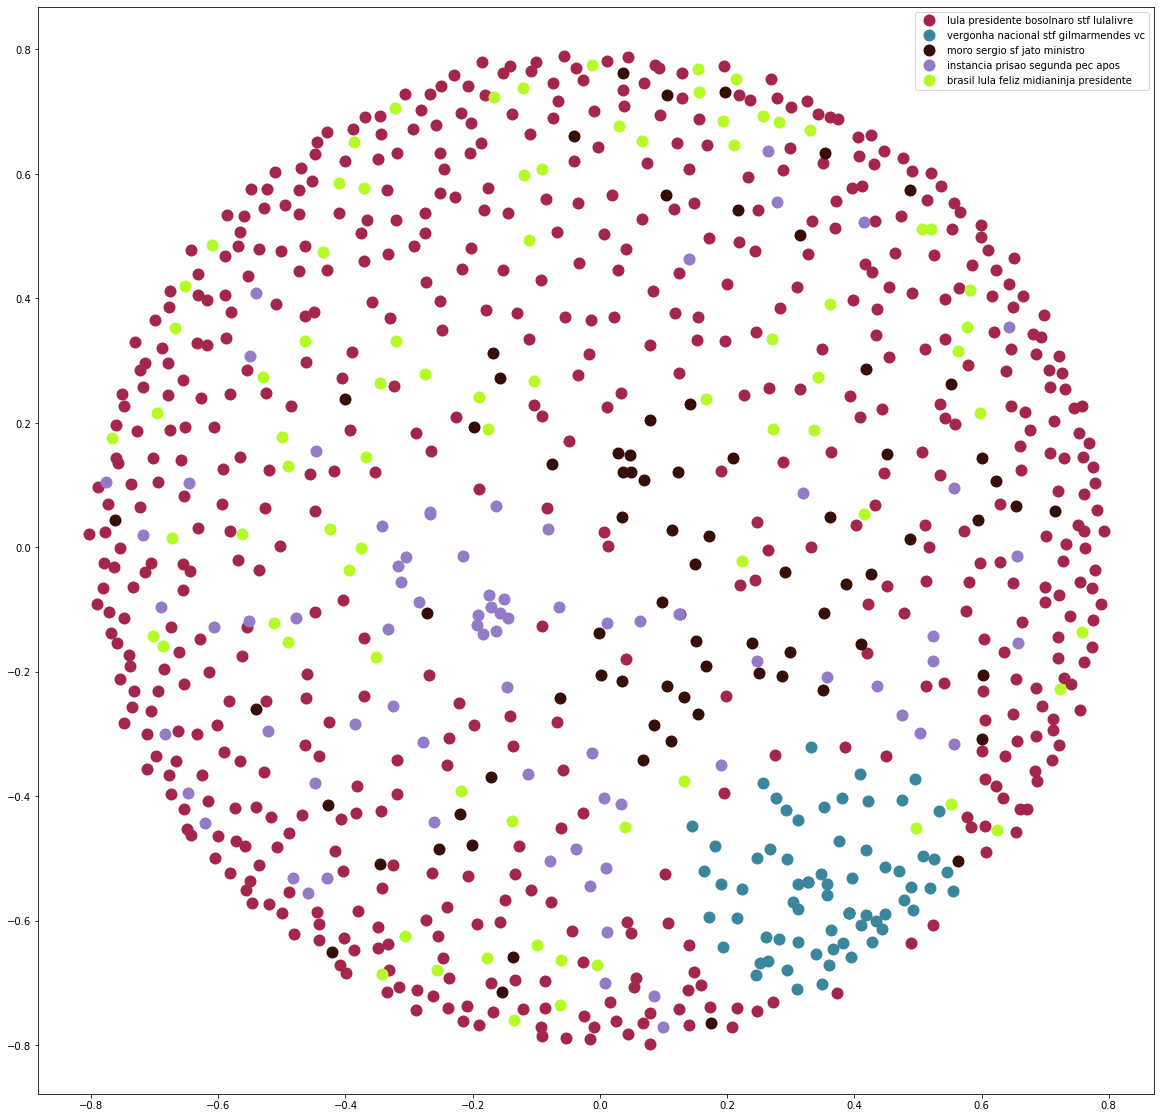

<Figure size 432x288 with 0 Axes>

In [256]:
title_df = [e[:3] for e in filtered_sentenses]
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=title_df)) 


groups = df.groupby('label') #agrupando elementos por label
fig, ax = plt.subplots(figsize=(20, 20)) 


for i, group in enumerate(groups):
    ax.plot(group[1].x, group[1].y, marker='o', linestyle='', ms=12, label=cluster_names[i], color=cluster_color[i], mec='none')

ax.legend(numpoints=1)  #show legend with only 1 point

plt.show()

plt.savefig(graphics_path+'cluster_{0}.png'.format(num_clusters), dpi=90)





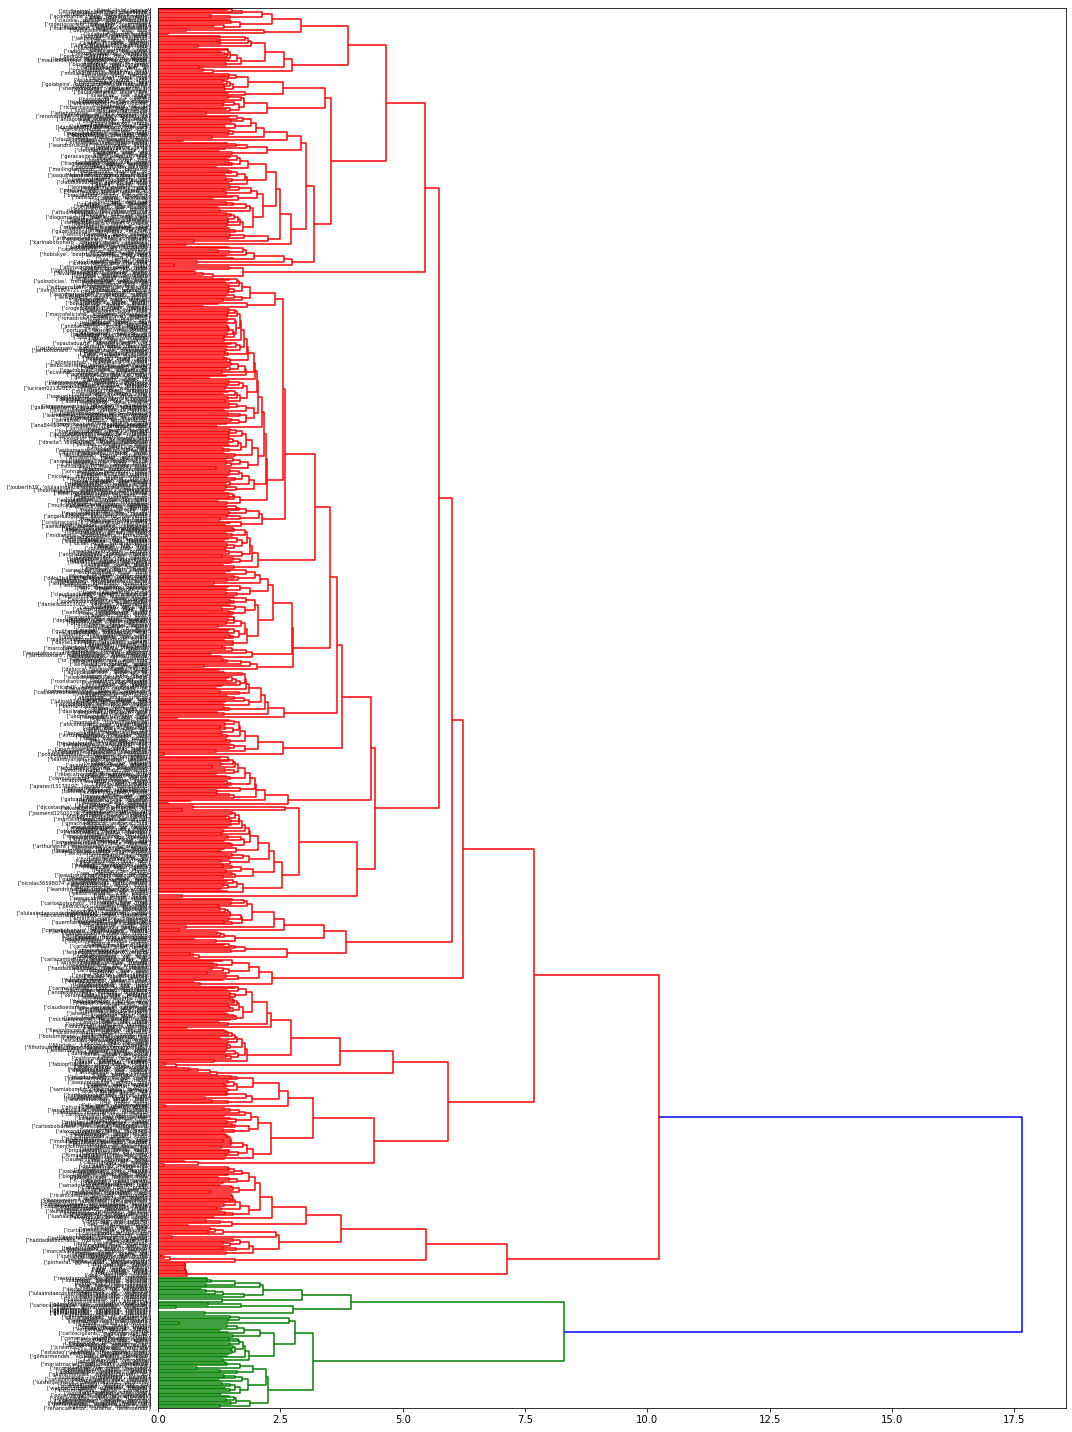

In [260]:


from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=title_df);

plt.tight_layout() #show plot with tight layout

plt.savefig(graphics_path+'demogram_c{0}.png'.format(num_clusters), dpi=200)
